### AI를 이용한 주가예측(multi_step)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Concatenate, Reshape, Input, Conv1D, Flatten, MaxPooling1D
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
df = pd.read_excel('D:\data\stock.xlsx')

In [7]:
df.columns

Index(['date', 'exchange_rate', 'basemoney_rate', 'ten_year_government_bond',
       'export_amount', 'M2', 'pbr', 'per', 'foreign_holdings', 'kospi'],
      dtype='object')

<AxesSubplot:>

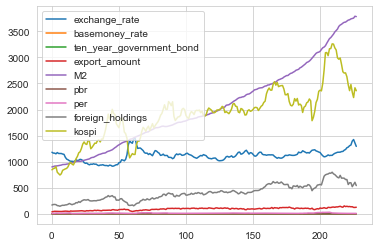

In [8]:
# 이 2개의 시계열을 한번에 모델링 해서
# 2개의 시계열을 각각 예측
df.plot()

In [9]:
# 년 단위로 차분 형성
df_transformed = (pd.DataFrame({'exchange_rate': np.log(df.exchange_rate).diff(12),
                                'basemoney_rate': np.log(df.basemoney_rate).diff(12),
                                'ten_year_government_bond' : np.log(df.ten_year_government_bond).diff(12),
                                'export_amount': np.log(df.export_amount).diff(12),
                                'M2' : np.log(df.M2).diff(12),
                                'pbr' : np.log(df.pbr).diff(12),
                                'per' : np.log(df.per).diff(12),
                                'foreign_holdings' : np.log(df.foreign_holdings).diff(12),
                                'kospi' : np.log(df.kospi).diff(12),                                
                                }
                               )
                  .dropna())

In [10]:
df_transformed = df_transformed.apply(minmax_scale)

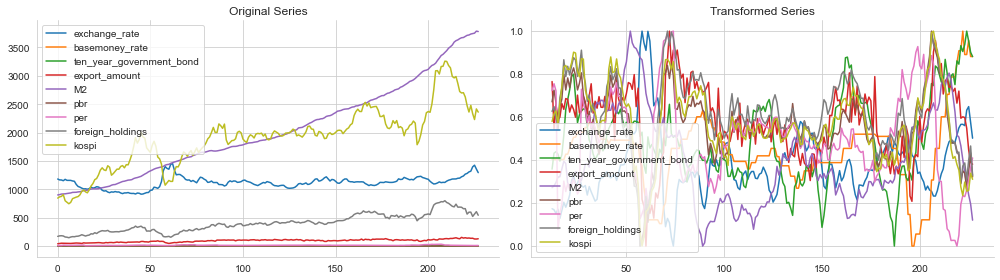

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
columns={'exchange_rate' : 'exchange_rate', 'basemoney_rate' : 'basemoney_rate',
         'ten_year_government_bond' : 'ten_year_government_bond', 'export_amount' : 'export_amount',
         'M2' : 'M2', 'pbr' : 'pbr', 'per' : 'per', 'foreign_holdings' : 'foreign_holdings', 'kospi' : 'kospi'}
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Transformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)

In [12]:
from numpy import array
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [13]:
window_size = 20
n_step_out = 6

In [14]:
X, y = split_sequence(df_transformed, window_size, n_step_out)

In [15]:
X.shape, y.shape

((191, 20, 9), (191, 6, 9))

In [16]:
y

array([[[0.25237683, 0.57246164, 0.47419325, ..., 0.54975973,
         0.62326594, 0.65186513],
        [0.23061143, 0.54558016, 0.42791235, ..., 0.57522565,
         0.66444101, 0.63523481],
        [0.20910615, 0.54558016, 0.40253595, ..., 0.55130627,
         0.61410897, 0.62194891],
        [0.2176139 , 0.52055409, 0.4195572 , ..., 0.51411748,
         0.57163335, 0.57244844],
        [0.29526092, 0.52055409, 0.43604263, ..., 0.48070518,
         0.55132768, 0.52060453],
        [0.31681647, 0.49714377, 0.47366978, ..., 0.50412195,
         0.60206061, 0.58055434]],

       [[0.23061143, 0.54558016, 0.42791235, ..., 0.57522565,
         0.66444101, 0.63523481],
        [0.20910615, 0.54558016, 0.40253595, ..., 0.55130627,
         0.61410897, 0.62194891],
        [0.2176139 , 0.52055409, 0.4195572 , ..., 0.51411748,
         0.57163335, 0.57244844],
        [0.29526092, 0.52055409, 0.43604263, ..., 0.48070518,
         0.55132768, 0.52060453],
        [0.31681647, 0.49714377, 0.473

In [17]:
test_size = 24
train_size = X.shape[0]-test_size

In [18]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [19]:
y_test

array([[[0.33779588, 0.05591571, 0.58294237, ..., 0.92818836,
         0.64890044, 0.68972854],
        [0.34413325, 0.05591571, 0.55557538, ..., 0.84002017,
         0.61722509, 0.65273584],
        [0.31630315, 0.12204995, 0.47907944, ..., 0.82465937,
         0.59648272, 0.63864971],
        [0.29851805, 0.12204995, 0.45008899, ..., 0.89186904,
         0.71141185, 0.66556425],
        [0.26083204, 0.12204995, 0.52383028, ..., 0.73983289,
         0.76211386, 0.74338352],
        [0.27891889, 0.12204995, 0.54754957, ..., 0.7769592 ,
         0.80060746, 0.82216753]],

       [[0.34413325, 0.05591571, 0.55557538, ..., 0.84002017,
         0.61722509, 0.65273584],
        [0.31630315, 0.12204995, 0.47907944, ..., 0.82465937,
         0.59648272, 0.63864971],
        [0.29851805, 0.12204995, 0.45008899, ..., 0.89186904,
         0.71141185, 0.66556425],
        [0.26083204, 0.12204995, 0.52383028, ..., 0.73983289,
         0.76211386, 0.74338352],
        [0.27891889, 0.12204995, 0.547

In [20]:
X_train.shape, X_test.shape

((167, 20, 9), (24, 20, 9))

In [21]:
K.clear_session()

In [22]:
n_features = output_size = 9

In [23]:
lstm_units = 200
dense_units = 128

In [24]:
# Seq2Seq LSTM to LSTM
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features),
         return_sequences=True),
      LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=False),
    RepeatVector(n_step_out),
      LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=True),
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=True),
    TimeDistributed(Dense(dense_units)),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(Dense(dense_units)),
    TimeDistributed(Dense(output_size))
])

In [25]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 200)           168000    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 repeat_vector (RepeatVector  (None, 6, 200)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 6, 200)            320800    
                                                                 
 lstm_3 (LSTM)               (None, 6, 200)            320800    
                                                                 
 time_distributed (TimeDistr  (None, 6, 128)           25728     
 ibuted)                                                

In [26]:
# CNN-LSTM
# rnn = Sequential([
#     Conv1D(filters=64, kernel_size=7, activation='relu',
# 	          input_shape=(window_size, n_features)), # 20, 2 => 20, 64
#     MaxPooling1D(pool_size=2), # 10, 64
#     Flatten(), # 640
#     RepeatVector(n_step_out),
#       LSTM(units=lstm_units,
#          dropout=.1,
#          recurrent_dropout=.1,
#         #  input_shape=(window_size, n_features),
#          return_sequences=True),
#     LSTM(units=lstm_units,
#          dropout=.1,
#          recurrent_dropout=.1,
#         #  input_shape=(window_size, n_features),
#          return_sequences=True),
#     TimeDistributed(Dense(dense_units)),
#     TimeDistributed(Dropout(0.5)),
#     TimeDistributed(Dense(dense_units)),
#     TimeDistributed(Dense(output_size))
# ])

In [27]:
# rnn.summary()

In [28]:
rnn.compile(loss='mse', optimizer='Adam')

In [29]:
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [31]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.1607
Epoch 1: val_loss improved from inf to 0.15327, saving model to results/multivariate_time_series\lstm.h5
9/9 [==============================] - 13s 325ms/step - loss: 0.1607 - val_loss: 0.1533
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.0741
Epoch 2: val_loss improved from 0.15327 to 0.11345, saving model to results/multivariate_time_series\lstm.h5
9/9 [==============================] - 2s 209ms/step - loss: 0.0741 - val_loss: 0.1135
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.0493
Epoch 3: val_loss improved from 0.11345 to 0.09278, saving model to results/multivariate_time_series\lstm.h5
9/9 [==============================] - 2s 254ms/step - loss: 0.0493 - val_loss: 0.0928
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.0378
Epoch 4: val_loss improved from 0.09278 to 0.07888, saving model to results/multivariate_time_series\lstm.h5
9/9 [=====

<AxesSubplot:>

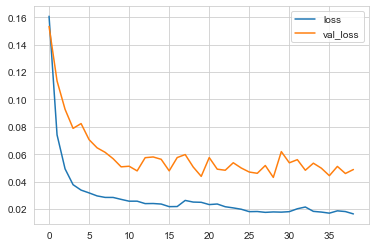

In [32]:
pd.DataFrame(result.history).plot()

In [33]:
pred = rnn.predict(X_test)

1/1 [==============================] - 1s 965ms/step


In [34]:
pred

array([[[0.42589527, 0.3464969 , 0.45041645, ..., 0.56719506,
         0.5914735 , 0.54423434],
        [0.45885283, 0.29281723, 0.4696195 , ..., 0.6365003 ,
         0.6007026 , 0.55809885],
        [0.4713781 , 0.24952924, 0.48519036, ..., 0.6847753 ,
         0.6079573 , 0.5707804 ],
        [0.4692687 , 0.22231789, 0.5006756 , ..., 0.7162113 ,
         0.6187445 , 0.5858539 ],
        [0.45892993, 0.20819788, 0.5157113 , ..., 0.7352077 ,
         0.63161284, 0.6017155 ],
        [0.44532514, 0.20247354, 0.52945626, ..., 0.7455191 ,
         0.64400864, 0.61620283]],

       [[0.4213475 , 0.36045414, 0.46216533, ..., 0.5734963 ,
         0.6103326 , 0.5607468 ],
        [0.44767517, 0.31703973, 0.48846737, ..., 0.64281964,
         0.6301143 , 0.58492446],
        [0.45437205, 0.27849916, 0.50574416, ..., 0.68608576,
         0.63852334, 0.60025835],
        [0.44841257, 0.25276926, 0.51983887, ..., 0.7106955 ,
         0.64540136, 0.6136357 ],
        [0.43619692, 0.23874044, 0.532

In [35]:
pred.shape

(24, 6, 9)

In [36]:
last_pred = pred[-1, :, :]

In [37]:
last_pred

array([[0.37790802, 0.43377563, 0.418213  , 0.53872305, 0.32197255,
        0.49181542, 0.44268325, 0.561685  , 0.5113884 ],
       [0.38407293, 0.4754316 , 0.3973695 , 0.52722746, 0.27925083,
        0.4543721 , 0.38008693, 0.5314643 , 0.48028228],
       [0.40077987, 0.5085203 , 0.37450513, 0.50730985, 0.25036955,
        0.4161852 , 0.3254226 , 0.4994543 , 0.44675845],
       [0.42485902, 0.5344558 , 0.3566897 , 0.48882136, 0.24004555,
        0.3864703 , 0.28771582, 0.47602674, 0.420433  ],
       [0.45095482, 0.5535957 , 0.34405968, 0.47382542, 0.24377093,
        0.36551964, 0.2646222 , 0.46109855, 0.40167663],
       [0.4751217 , 0.5668759 , 0.33519998, 0.46189374, 0.2556178 ,
        0.35140422, 0.2515772 , 0.45220175, 0.3888418 ]], dtype=float32)

In [38]:
last_pred.shape

(6, 9)

In [39]:
y_pred = pd.DataFrame(last_pred, 
                      columns = ['exchange_rate', 'basemoney_rate', 'ten_year_government_bond', 'export_amount',
                                 'M2', 'pbr', 'per', 'foreign_holdings', 'kospi'])
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   exchange_rate             6 non-null      float32
 1   basemoney_rate            6 non-null      float32
 2   ten_year_government_bond  6 non-null      float32
 3   export_amount             6 non-null      float32
 4   M2                        6 non-null      float32
 5   pbr                       6 non-null      float32
 6   per                       6 non-null      float32
 7   foreign_holdings          6 non-null      float32
 8   kospi                     6 non-null      float32
dtypes: float32(9)
memory usage: 344.0 bytes


<AxesSubplot:>

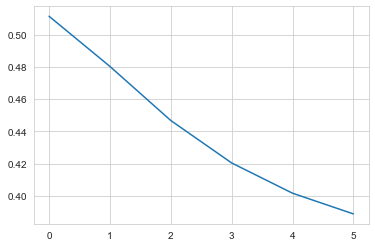

In [40]:
y_pred['kospi'].plot()

In [41]:
y_test

array([[[0.33779588, 0.05591571, 0.58294237, ..., 0.92818836,
         0.64890044, 0.68972854],
        [0.34413325, 0.05591571, 0.55557538, ..., 0.84002017,
         0.61722509, 0.65273584],
        [0.31630315, 0.12204995, 0.47907944, ..., 0.82465937,
         0.59648272, 0.63864971],
        [0.29851805, 0.12204995, 0.45008899, ..., 0.89186904,
         0.71141185, 0.66556425],
        [0.26083204, 0.12204995, 0.52383028, ..., 0.73983289,
         0.76211386, 0.74338352],
        [0.27891889, 0.12204995, 0.54754957, ..., 0.7769592 ,
         0.80060746, 0.82216753]],

       [[0.34413325, 0.05591571, 0.55557538, ..., 0.84002017,
         0.61722509, 0.65273584],
        [0.31630315, 0.12204995, 0.47907944, ..., 0.82465937,
         0.59648272, 0.63864971],
        [0.29851805, 0.12204995, 0.45008899, ..., 0.89186904,
         0.71141185, 0.66556425],
        [0.26083204, 0.12204995, 0.52383028, ..., 0.73983289,
         0.76211386, 0.74338352],
        [0.27891889, 0.12204995, 0.547

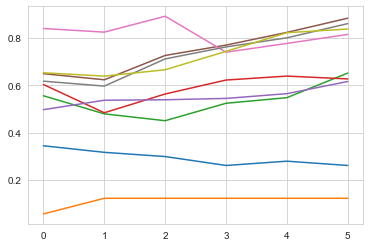

In [42]:
plt.plot(y_test[1])

In [43]:
test_mae_loss = np.mean(np.abs(pred - y_test), axis=1)

In [44]:
test_mae_loss

array([[0.14885812, 0.15363358, 0.05023194, 0.08276616, 0.04683091,
        0.12355768, 0.15268671, 0.07753187, 0.12255727],
       [0.14512737, 0.16900278, 0.04756371, 0.05933761, 0.03303995,
        0.13975707, 0.13725453, 0.0964282 , 0.12273695],
       [0.14196773, 0.17271409, 0.0636794 , 0.04652153, 0.03472469,
        0.18537603, 0.16035959, 0.13678931, 0.15818489],
       [0.14148494, 0.16266972, 0.09179778, 0.05885214, 0.0476447 ,
        0.2331241 , 0.18891053, 0.17142879, 0.20562597],
       [0.13852884, 0.17509679, 0.13926274, 0.10238607, 0.07655812,
        0.26015776, 0.17554068, 0.19570587, 0.24207234],
       [0.12404383, 0.16012102, 0.18539498, 0.13024691, 0.1119725 ,
        0.27594077, 0.20701117, 0.21000078, 0.25880638],
       [0.10612375, 0.11365533, 0.22357968, 0.12831033, 0.14955953,
        0.2714631 , 0.21541925, 0.20378368, 0.25878917],
       [0.08038517, 0.0940566 , 0.23850833, 0.1188218 , 0.18944753,
        0.25381536, 0.20181377, 0.18389086, 0.24250696],
